In [6]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import platform
import roadrunner
import math

# Silence RoadRunner log messages completely
roadrunner.Logger.setLevel(roadrunner.Logger.LOG_CRITICAL)

# Cross-platform path detection
def get_model_path():
    """Get the correct path to the SBML model file based on OS and available paths."""
    # Define possible paths
    linux_path = "/home/gijs/Documents/OxfordEvolution/Yeast/Chen/chen2004_biomd56.xml"
    mac_path = "/Users/gijsbartholomeus/Documents/STUDIE/OxfordEvolution/code/Yeast/Chen/chen2004_biomd56.xml"
    
    # Check which path exists
    if os.path.exists(linux_path):
        return linux_path
    elif os.path.exists(mac_path):
        return mac_path
    else:
        # Fallback: try to find it relative to current directory
        possible_relative_paths = [
            "chen2004_biomd56.xml",
            "Chen/chen2004_biomd56.xml",
            "../Chen/chen2004_biomd56.xml"
        ]
        for rel_path in possible_relative_paths:
            if os.path.exists(rel_path):
                return os.path.abspath(rel_path)
        
        # If nothing found, raise an error with helpful message
        raise FileNotFoundError(
            f"Could not find chen2004_biomd56.xml in any of the expected locations:\n"
            f"  Linux: {linux_path}\n"
            f"  Mac: {mac_path}\n"
            f"Current working directory: {os.getcwd()}\n"
            f"Platform: {platform.system()}"
        )

# Load Chen 2004 budding yeast cell cycle model
model_path = get_model_path()
print(f"Loading model from: {model_path}")
rr = te.loadSBMLModel(model_path)



Loading model from: /Users/gijsbartholomeus/Documents/STUDIE/OxfordEvolution/code/Yeast/Chen/chen2004_biomd56.xml


In [66]:
# === SIMULATION CONFIGURATION ===
# Adjust these parameters to control simulation behavior

# Parameter sampling configuration
multipliers = [0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00]  # Discrete multipliers for parameter perturbation

# Simulation thresholds and limits
DIVERGENCE_THRESHOLD = None     # Set to a value (e.g., 1000) to reject divergent solutions, or None to allow all
MAX_PERIOD_THRESHOLD = 300     # Set to a value (e.g., 500) to reject long periods, or None to allow all
SIMULATION_TIME = 1000          # Total simulation time in minutes
SIMULATION_POINTS = 1001        # Number of time points in simulation

# Analysis configuration  
MAX_RETRY_ATTEMPTS = 20         # Maximum attempts to find oscillating solution in tests
SAMPLING_SIZE = 5000            # Number of phenotypes to sample in main analysis
PROGRESS_INTERVAL = 0.05        # Progress reporting frequency (5% intervals)

# Phenotype tracking
N_TRACK_PHENOTYPES = 5          # Number of top/bottom phenotypes to track during sampling

print("✓ Configuration loaded:")
print(f"   - Multipliers: {multipliers}")
print(f"   - Divergence threshold: {DIVERGENCE_THRESHOLD}")
print(f"   - Max period threshold: {MAX_PERIOD_THRESHOLD}")
print(f"   - Simulation: {SIMULATION_TIME} min, {SIMULATION_POINTS} points")
print(f"   - Retry attempts: {MAX_RETRY_ATTEMPTS}")
print(f"   - Sampling size: {SAMPLING_SIZE}")

# === REQUIRED FUNCTION DEFINITIONS ===
# These functions are essential for the analysis pipeline

def get_kinetic_parameters(rr):
    """Get list of kinetic parameters, excluding regulatory switches/flags."""
    kinetic_params = []
    excluded_params = []
    
    for pid in rr.getGlobalParameterIds():
        value = rr.getValue(pid)
        param_lower = pid.lower()
        
        # Exclude non-kinetic parameters (switches, flags, totals)
        if (param_lower.endswith('t') and value in [0.0, 1.0]) or \
           (param_lower.startswith('d') and param_lower.endswith('n')) or \
           ('flag' in param_lower) or \
           ('switch' in param_lower) or \
           (value == 0.0) or \
           (pid in ['cell']) or \
           ('total' in param_lower and value in [0.0, 1.0]):
            excluded_params.append(pid)
        else:
            kinetic_params.append(pid)
    
    return kinetic_params, excluded_params

def sample_parameters(rr, wildtype=False):
    """Scale only kinetic parameters by random factors (matches paper's 156 parameters).
    Excludes regulatory switches and flags to match the paper exactly."""
    
    # First, reset the model to ensure clean state
    rr.resetAll()
    
    # Get kinetic parameters only
    kinetic_params, excluded_params = get_kinetic_parameters(rr)
    
    sampled = {}
    sampled_values = []  # Just the values for quick printing
    
    if wildtype:
        # For wildtype, don't change any parameters - just return empty
        return sampled, sampled_values
    
    # Sample only kinetic parameters
    for pid in kinetic_params:
        try:
            current = rr.getValue(pid)
            factor = random.choice(multipliers)
            rr.setValue(pid, current * factor)
            sampled[pid] = factor
            sampled_values.append(factor)
        except RuntimeError:
            continue
    
    # Keep excluded parameters at their original values (don't sample them)
    # This ensures regulatory switches stay fixed
    
    return sampled, sampled_values

def check_divergence(result, threshold):
    """Check if simulation results contain values exceeding threshold."""
    if threshold is None:
        return False
    return np.any(np.abs(result) > threshold)

def simulate_and_extract(rr, tmax=200, npoints=2001):
    rr.selections = ["time"] + rr.getFloatingSpeciesIds()
    try:
        result = rr.simulate(0, tmax, npoints)
    except RuntimeError as e:
        # Any CVODE failure: return None
        return None, None

    time = result[:, 0]
    cols = rr.selections

    clb2 = result[:, cols.index("CLB2")]
    signal = clb2  # Use only CLB2, not the product
    return time, signal

def up_down_encoding(time, signal, nbins=50):
    """Binary string of slope signs at evenly spaced time bins.
    Following Fink method: evaluate slopes at δt, 2δt, ..., T (starting at δt)."""
    bits = []
    dt = (time[-1] - time[0]) / nbins  # bin width
    
    # Start from the first bin edge (δt), not from t=0
    for i in range(1, nbins + 1):
        t_eval = time[0] + i * dt  # δt, 2δt, 3δt, ...
        
        # Ensure we don't go beyond the time series
        if t_eval > time[-1]:
            break
            
        # Get signal values at t_eval and slightly before
        t_before = t_eval - dt/10  # Small step back to compute slope
        if t_before < time[0]:
            t_before = time[0]
            
        val_before = np.interp(t_before, time, signal)
        val_now = np.interp(t_eval, time, signal)
        
        slope = val_now - val_before
        bits.append("1" if slope >= 0 else "0")
    
    return "".join(bits)

def lz76_phrase_count(s: str) -> int:
    n = len(s)
    if n == 0:
        return 0
    i = 0
    c = 1  # at least one phrase if n>0
    k = 1
    while i + k <= n:
        if s[i:i+k] in s[:i]:
            k += 1
            if i + k - 1 > n:
                c += 1
                break
        else:
            c += 1
            i += k
            k = 1
    return c

def CLZ(x):
    """Lempel-Ziv complexity as described in the prompt."""
    n = len(x)
    if x.count('0') == n or x.count('1') == n:
        return math.log2(n)
    else:
        return math.log2(n) / 2 * (lz76_phrase_count(x) + lz76_phrase_count(x[::-1]))

# Additional functions needed for paper method
def estimate_period(time, signal):
    """Estimate period using autocorrelation method and extract one full cycle."""
    # Use the last 80% of the signal to avoid transients
    start_idx = int(0.2 * len(signal))
    time_subset = time[start_idx:]
    signal_subset = signal[start_idx:]
    
    # Normalize signal for autocorrelation
    signal_norm = (signal_subset - np.mean(signal_subset)) / np.std(signal_subset)
    
    # Compute autocorrelation
    autocorr = np.correlate(signal_norm, signal_norm, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    
    # Find the first significant peak after lag 0
    # Look for peaks that are at least 50% of the max autocorr value
    threshold = 0.5 * np.max(autocorr[1:])  # Exclude lag 0
    peaks = []
    
    for i in range(1, len(autocorr) - 1):
        if (autocorr[i] > autocorr[i-1] and 
            autocorr[i] > autocorr[i+1] and 
            autocorr[i] > threshold):
            peaks.append(i)
    
    if not peaks:
        return None, None
    
    # Period in time units
    dt = time_subset[1] - time_subset[0]
    period_samples = peaks[0]
    period = period_samples * dt
    
    # Extract one full cycle - look for a cycle in the middle of the trajectory
    # Find the second peak to center the window around it
    signal_mean = np.mean(signal_subset)
    peaks_in_signal = []
    
    # Find peaks in the actual signal (not autocorrelation)
    for i in range(1, len(signal_subset) - 1):
        if (signal_subset[i] > signal_subset[i-1] and 
            signal_subset[i] > signal_subset[i+1] and 
            signal_subset[i] > signal_mean):
            peaks_in_signal.append(i)
    
    if len(peaks_in_signal) >= 2:
        # Use the second peak as center
        center_idx = peaks_in_signal[1]
        half_period = period_samples // 2
        cycle_start_idx = max(0, center_idx - half_period)
        cycle_end_idx = min(len(time_subset), center_idx + half_period)
    else:
        # Fallback to end of trajectory
        cycle_start_idx = len(time_subset) - period_samples
        cycle_end_idx = len(time_subset)
        if cycle_start_idx < 0:
            return None, None
    
    # Get the cycle data
    cycle_time = time_subset[cycle_start_idx:cycle_end_idx]
    cycle_signal = signal_subset[cycle_start_idx:cycle_end_idx]
    
    # Ensure we have a reasonable amount of data
    if len(cycle_time) < 10:
        return None, None
    
    return period, (cycle_time, cycle_signal)

def coarse_grain_to_50_steps(cycle_time, cycle_signal):
    """Coarse-grain a cycle to exactly 50 steps using interpolation."""
    if len(cycle_time) < 10:  # Need minimum data points
        return None, None
    
    # Create 50 evenly spaced time points across the cycle
    t_start = cycle_time[0]
    t_end = cycle_time[-1]
    coarse_time = np.linspace(t_start, t_end, 50)
    
    # Interpolate signal values at these time points
    coarse_signal = np.interp(coarse_time, cycle_time, cycle_signal)
    
    return coarse_time, coarse_signal

def up_down_encoding_paper_method(coarse_time, coarse_signal):
    """Convert coarse-grained signal to binary up/down encoding (49 transitions)."""
    # Calculate slopes between consecutive points
    slopes = np.diff(coarse_signal) / np.diff(coarse_time)
    
    # Convert to binary: 1 for positive slope (up), 0 for negative slope (down)
    encoding = ''.join(['1' if s > 0 else '0' for s in slopes])
    
    return encoding

def simulate_and_extract_paper_method(rr, tmax=None, npoints=None, diverge_threshold=None, maxperiod_threshold=None):
    """Simulate using paper's method: 1000 time steps, period detection, coarse-graining.
    Returns None for divergent solutions if diverge_threshold is set.
    Returns 'longperiod' for periods exceeding maxperiod_threshold."""
    
    # Use configuration defaults if not specified
    if tmax is None:
        tmax = SIMULATION_TIME
    if npoints is None:
        npoints = SIMULATION_POINTS
    if diverge_threshold is None:
        diverge_threshold = DIVERGENCE_THRESHOLD
    if maxperiod_threshold is None:
        maxperiod_threshold = MAX_PERIOD_THRESHOLD
    rr.selections = ["time"] + rr.getFloatingSpeciesIds()
    try:
        result = rr.simulate(0, tmax, npoints)
    except RuntimeError as e:
        return None, None, None, None

    # Check for divergent solutions
    if check_divergence(result, diverge_threshold):
        return "divergent", None, None, None

    time = result[:, 0]
    cols = rr.selections
    clb2 = result[:, cols.index("CLB2")]
    
    # Estimate period using your strategy
    period, cycle_data = estimate_period(time, clb2)
    
    if period is None or cycle_data is None:
        return None, None, None, None
    
    # Check for periods that are too long
    if maxperiod_threshold is not None and period > maxperiod_threshold:
        return "longperiod", None, None, None
    
    cycle_time, cycle_signal = cycle_data
    
    # Coarse-grain to 50 steps
    coarse_time, coarse_signal = coarse_grain_to_50_steps(cycle_time, cycle_signal)
    
    if coarse_time is None:
        return None, None, None, None
    
    return time, clb2, period, (coarse_time, coarse_signal)

print("✓ All required functions defined successfully!")

✓ Configuration loaded:
   - Multipliers: [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
   - Divergence threshold: None
   - Max period threshold: 300
   - Simulation: 1000 min, 1001 points
   - Retry attempts: 20
   - Sampling size: 5000
✓ All required functions defined successfully!


=== COMPREHENSIVE SYSTEM TEST ===

3. RANDOMIZED PARAMETER TEST:

3. RANDOMIZED PARAMETER TEST:
   ✓ Success on attempt 2
   ✓ Parameters modified: 136
   ✓ Period: 237.0 min
   ✓ Complexity: 47.725
   ✓ Encoding: 111111111111111111111111000011...

4. VISUALIZATION:
   Creating comparison plots...
   ✓ Success on attempt 2
   ✓ Parameters modified: 136
   ✓ Period: 237.0 min
   ✓ Complexity: 47.725
   ✓ Encoding: 111111111111111111111111000011...

4. VISUALIZATION:
   Creating comparison plots...


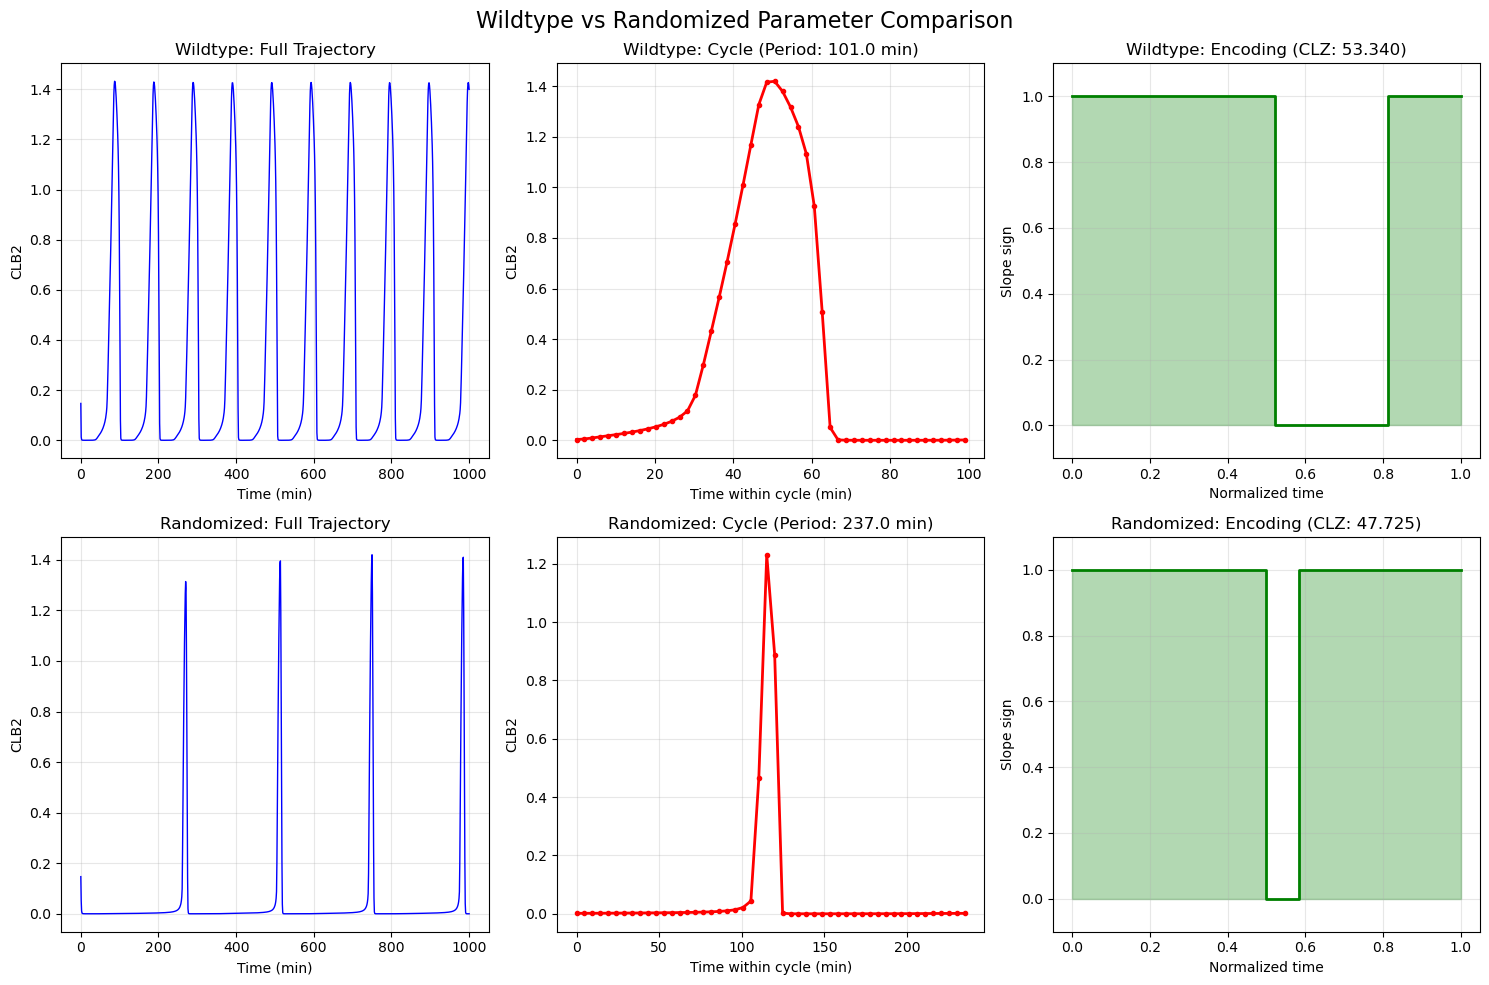


5. SYSTEM STATUS:
   ✅ SYSTEM FULLY OPERATIONAL
   - Wildtype working correctly
   - Random parameter sampling working
   - Ready for large-scale analysis

=== TEST COMPLETE ===


In [68]:
# === COMPREHENSIVE SYSTEM TEST ===
print("=== COMPREHENSIVE SYSTEM TEST ===")

# Test parameter structure
rr_test = te.loadSBMLModel(model_path)
kinetic_params, excluded_params = get_kinetic_parameters(rr_test)

rr_wt = te.loadSBMLModel(model_path)
sampled_wt, values_wt = sample_parameters(rr_wt, wildtype=True)


full_time_wt, full_clb2_wt, period_wt, coarse_data_wt = simulate_and_extract_paper_method(rr_wt)
if period_wt is not None:
    coarse_time_wt, coarse_signal_wt = coarse_data_wt
    encoding_wt = up_down_encoding_paper_method(coarse_time_wt, coarse_signal_wt)
    complexity_wt = CLZ(encoding_wt)
    wildtype_success = True
else:
    print("   ✗ Wildtype failed!")
    wildtype_success = False

# Test randomized parameters (keep trying until success)
print("\n3. RANDOMIZED PARAMETER TEST:")
max_attempts = MAX_RETRY_ATTEMPTS
success = False

for attempt in range(max_attempts):
    rr_rand = te.loadSBMLModel(model_path)
    sampled_rand, values_rand = sample_parameters(rr_rand, wildtype=False)
    
    full_time_rand, full_clb2_rand, period_rand, coarse_data_rand = simulate_and_extract_paper_method(rr_rand)
    
    if period_rand is not None:
        coarse_time_rand, coarse_signal_rand = coarse_data_rand
        encoding_rand = up_down_encoding_paper_method(coarse_time_rand, coarse_signal_rand)
        complexity_rand = CLZ(encoding_rand)
        
        print(f"   ✓ Success on attempt {attempt + 1}")
        print(f"   ✓ Parameters modified: {len(values_rand)}")
        print(f"   ✓ Period: {period_rand:.1f} min")
        print(f"   ✓ Complexity: {complexity_rand:.3f}")
        print(f"   ✓ Encoding: {encoding_rand[:30]}...")
        success = True
        break
    else:
        if (attempt + 1) % 5 == 0:  # Print every 5 attempts
            print(f"   - Attempts 1-{attempt + 1}: No oscillation found")

if not success:
    print(f"   ✗ Failed after {max_attempts} attempts")

# Show visualization if either test succeeded
print("\n4. VISUALIZATION:")
if wildtype_success and success:
    print("   Creating comparison plots...")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Wildtype vs Randomized Parameter Comparison", fontsize=16)
    
    # Wildtype plots
    axes[0, 0].plot(full_time_wt, full_clb2_wt, 'b-', linewidth=1)
    axes[0, 0].set_title("Wildtype: Full Trajectory")
    axes[0, 0].set_xlabel("Time (min)")
    axes[0, 0].set_ylabel("CLB2")
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(coarse_time_wt - coarse_time_wt[0], coarse_signal_wt, 'ro-', markersize=3, linewidth=2)
    axes[0, 1].set_title(f"Wildtype: Cycle (Period: {period_wt:.1f} min)")
    axes[0, 1].set_xlabel("Time within cycle (min)")
    axes[0, 1].set_ylabel("CLB2")
    axes[0, 1].grid(True, alpha=0.3)
    
    step_time = np.linspace(0, 1, 49)
    encoding_values_wt = [int(bit) for bit in encoding_wt]
    axes[0, 2].step(step_time, encoding_values_wt, 'g-', linewidth=2, where='post')
    axes[0, 2].fill_between(step_time, 0, encoding_values_wt, step='post', alpha=0.3, color='green')
    axes[0, 2].set_title(f"Wildtype: Encoding (CLZ: {complexity_wt:.3f})")
    axes[0, 2].set_xlabel("Normalized time")
    axes[0, 2].set_ylabel("Slope sign")
    axes[0, 2].set_ylim(-0.1, 1.1)
    axes[0, 2].grid(True, alpha=0.3)
    
    # Randomized plots
    axes[1, 0].plot(full_time_rand, full_clb2_rand, 'b-', linewidth=1)
    axes[1, 0].set_title("Randomized: Full Trajectory")
    axes[1, 0].set_xlabel("Time (min)")
    axes[1, 0].set_ylabel("CLB2")
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(coarse_time_rand - coarse_time_rand[0], coarse_signal_rand, 'ro-', markersize=3, linewidth=2)
    axes[1, 1].set_title(f"Randomized: Cycle (Period: {period_rand:.1f} min)")
    axes[1, 1].set_xlabel("Time within cycle (min)")
    axes[1, 1].set_ylabel("CLB2")
    axes[1, 1].grid(True, alpha=0.3)
    
    encoding_values_rand = [int(bit) for bit in encoding_rand]
    axes[1, 2].step(step_time, encoding_values_rand, 'g-', linewidth=2, where='post')
    axes[1, 2].fill_between(step_time, 0, encoding_values_rand, step='post', alpha=0.3, color='green')
    axes[1, 2].set_title(f"Randomized: Encoding (CLZ: {complexity_rand:.3f})")
    axes[1, 2].set_xlabel("Normalized time")
    axes[1, 2].set_ylabel("Slope sign")
    axes[1, 2].set_ylim(-0.1, 1.1)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
elif wildtype_success:
    print("   Creating wildtype plot...")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(full_time_wt, full_clb2_wt, 'b-', linewidth=1)
    plt.title("Wildtype: Full Trajectory")
    plt.xlabel("Time (min)")
    plt.ylabel("CLB2")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(coarse_time_wt - coarse_time_wt[0], coarse_signal_wt, 'ro-', markersize=4, linewidth=2)
    plt.title(f"Wildtype: Cycle (Period: {period_wt:.1f} min)")
    plt.xlabel("Time within cycle (min)")
    plt.ylabel("CLB2")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    step_time = np.linspace(0, 1, 49)
    encoding_values_wt = [int(bit) for bit in encoding_wt]
    plt.step(step_time, encoding_values_wt, 'g-', linewidth=2, where='post')
    plt.fill_between(step_time, 0, encoding_values_wt, step='post', alpha=0.3, color='green')
    plt.title(f"Wildtype: Encoding (CLZ: {complexity_wt:.3f})")
    plt.xlabel("Normalized time")
    plt.ylabel("Slope sign")
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("   No successful simulations to plot")

# Summary
print("\n5. SYSTEM STATUS:")
if wildtype_success and success:
    print("   ✅ SYSTEM FULLY OPERATIONAL")
    print("   - Wildtype working correctly")
    print("   - Random parameter sampling working")
    print("   - Ready for large-scale analysis")
elif wildtype_success:
    print("   ⚠️  SYSTEM PARTIALLY OPERATIONAL")
    print("   - Wildtype working correctly")
    print("   - Random parameters challenging but achievable")
else:
    print("   ❌ SYSTEM NEEDS DEBUGGING")
    print("   - Basic wildtype simulation failing")

print("\n=== TEST COMPLETE ===")

Starting parameter sampling loop...
Process: Load fresh model -> Randomize parameters -> Simulate -> Extract phenotype -> Reset
Configuration: N=5000, divergence_threshold=None, max_period_threshold=300
Simulation: 1000 min, 1001 points
Tracking top 5 phenotypes by frequency and complexity
Failure tracking: divergence -> oscillation -> period threshold

1/5000 (0.0%) | success: 0 | skip: 1 | elapsed: 0.0m | ETA: 17:09 (13.1m left)
250/5000 (5.0%) | success: 38 | skip: 212 | elapsed: 0.5m | ETA: 17:06 (10.2m left)
250/5000 (5.0%) | success: 38 | skip: 212 | elapsed: 0.5m | ETA: 17:06 (10.2m left)
500/5000 (10.0%) | success: 69 | skip: 431 | elapsed: 1.1m | ETA: 17:06 (9.8m left)
500/5000 (10.0%) | success: 69 | skip: 431 | elapsed: 1.1m | ETA: 17:06 (9.8m left)
750/5000 (15.0%) | success: 108 | skip: 642 | elapsed: 1.6m | ETA: 17:06 (9.2m left)
750/5000 (15.0%) | success: 108 | skip: 642 | elapsed: 1.6m | ETA: 17:06 (9.2m left)
1000/5000 (20.0%) | success: 147 | skip: 853 | elapsed: 2.2

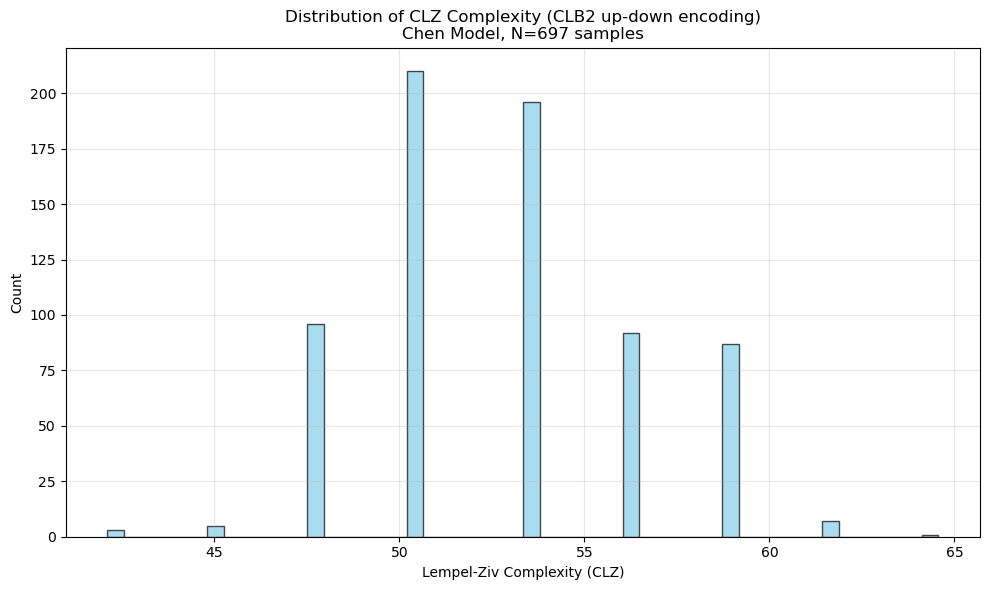

Wildtype phenotype rank: 7 (frequency: 31)


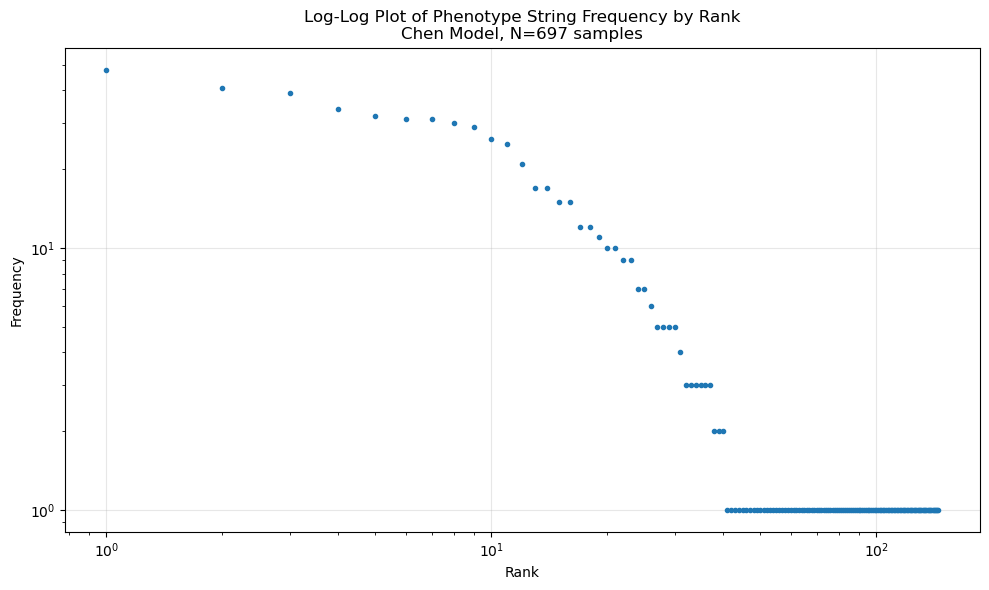

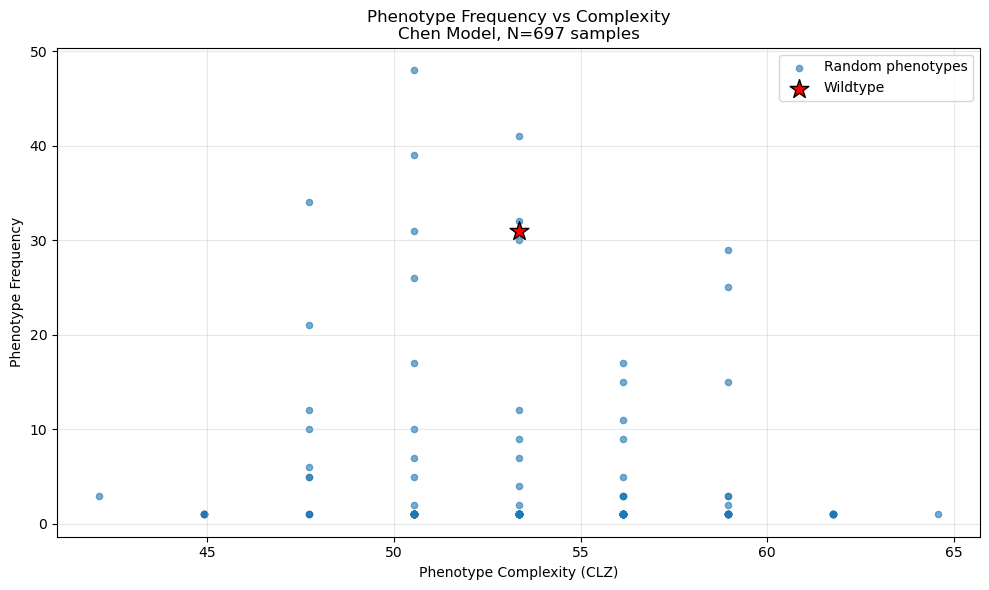


Plots saved to 'plots/' directory:
  - Chen_complexity_distribution_N697.png
  - Chen_rank_frequency_loglog_N697.png
  - Chen_frequency_vs_complexity_N697.png


In [69]:
import matplotlib.pyplot as plt
from collections import Counter
import time
from datetime import datetime, timedelta
import heapq

def print_progress(i, total, start_time, successful_count, skipped_count, interval=None):
    """Print progress every 'interval' fraction of total samples (default from config)"""
    if interval is None:
        interval = PROGRESS_INTERVAL
    # Calculate how many samples represent one interval
    interval_size = max(1, int(total * interval))
    
    # Only print at exact intervals or for the first/last sample
    if (i + 1) % interval_size == 0 or i == 0 or i == total - 1:
        elapsed = time.time() - start_time
        progress = (i + 1) / total
        if progress > 0:
            eta = datetime.now() + timedelta(seconds=elapsed / progress * (1 - progress))
            print(f"{i+1}/{total} ({progress*100:.1f}%) | success: {successful_count} | skip: {skipped_count} | "
                  f"elapsed: {elapsed/60:.1f}m | ETA: {eta.strftime('%H:%M')} ({elapsed/progress*(1-progress)/60:.1f}m left)")

class PhenotypeTracker:
    """Track top and bottom phenotypes by frequency and complexity during sampling"""
    def __init__(self, n_track=None):
        if n_track is None:
            n_track = N_TRACK_PHENOTYPES
        self.n_track = n_track
        self.phenotype_counts = Counter()
        self.counter = 0  # Unique counter for tie-breaking in heaps
        
        # Track top N most frequent (use min-heap, so we can easily remove smallest)
        self.top_frequent = []  # [(freq, counter, data_tuple), ...]
        
        # Track top N most complex (use min-heap)
        self.top_complex = []   # [(complexity, counter, data_tuple), ...]
        
        # Track bottom N least complex (use max-heap with negative values)
        self.bottom_complex = [] # [(-complexity, counter, data_tuple), ...]
    
    def update(self, encoding, genotype, phenotype_data):
        """Update trackers with new phenotype"""
        complexity = CLZ(encoding)
        self.phenotype_counts[encoding] += 1
        freq = self.phenotype_counts[encoding]
        
        # Data tuple: (encoding, genotype, phenotype_data)
        data_tuple = (encoding, genotype.copy(), phenotype_data)
        
        # Increment counter for unique ordering (avoids comparison of non-comparable objects)
        self.counter += 1
        
        # Update top frequent
        if len(self.top_frequent) < self.n_track:
            heapq.heappush(self.top_frequent, (freq, self.counter, data_tuple))
        elif freq > self.top_frequent[0][0]:
            heapq.heapreplace(self.top_frequent, (freq, self.counter, data_tuple))
        
        # Update top complex
        if len(self.top_complex) < self.n_track:
            heapq.heappush(self.top_complex, (complexity, self.counter, data_tuple))
        elif complexity > self.top_complex[0][0]:
            heapq.heapreplace(self.top_complex, (complexity, self.counter, data_tuple))
        
        # Update bottom complex (least complex)
        if len(self.bottom_complex) < self.n_track:
            heapq.heappush(self.bottom_complex, (-complexity, self.counter, data_tuple))
        elif complexity < -self.bottom_complex[0][0]:
            heapq.heapreplace(self.bottom_complex, (-complexity, self.counter, data_tuple))
    
    def get_top_frequent(self):
        """Get top frequent phenotypes, sorted by frequency (highest first)"""
        return sorted([(freq, data_tuple) for freq, counter, data_tuple in self.top_frequent], key=lambda x: x[0], reverse=True)
    
    def get_top_complex(self):
        """Get most complex phenotypes, sorted by complexity (highest first)"""
        return sorted([(complexity, data_tuple) for complexity, counter, data_tuple in self.top_complex], key=lambda x: x[0], reverse=True)
    
    def get_bottom_complex(self):
        """Get least complex phenotypes, sorted by complexity (lowest first)"""
        return sorted([(-neg_complexity, data_tuple) for neg_complexity, counter, data_tuple in self.bottom_complex], key=lambda x: x[0])

N = SAMPLING_SIZE
encodings = []
complexities = []

# Detailed failure tracking (in order of checks)
divergent_count = 0      # Failed divergence check
no_oscillation_count = 0 # Failed oscillation detection  
long_period_count = 0    # Failed period threshold check
success_count = 0        # Passed all checks

start_time = time.time()

# Initialize phenotype tracker (uses N_TRACK_PHENOTYPES from config)
tracker = PhenotypeTracker()

print("Starting parameter sampling loop...")
print("Process: Load fresh model -> Randomize parameters -> Simulate -> Extract phenotype -> Reset")
print(f"Configuration: N={N}, divergence_threshold={DIVERGENCE_THRESHOLD}, max_period_threshold={MAX_PERIOD_THRESHOLD}")
print(f"Simulation: {SIMULATION_TIME} min, {SIMULATION_POINTS} points")
print(f"Tracking top {N_TRACK_PHENOTYPES} phenotypes by frequency and complexity")
print(f"Failure tracking: divergence -> oscillation -> period threshold\n")

for i in range(N):
    # RESET: Load fresh model (this resets all parameters to original values)
    rr = te.loadSBMLModel(model_path)  
    
    # RANDOMIZE: Sample new random multipliers for kinetic parameters only
    sampled_params, sampled_values = sample_parameters(rr)  # Get the actual parameters used
    
    # SIMULATE: Run simulation with randomized parameters using paper method
    full_time, full_clb2, period, coarse_data = simulate_and_extract_paper_method(rr)

    # Classify result based on return values (in order of checks)
    if isinstance(full_time, str) and full_time == "divergent":
        divergent_count += 1
    elif isinstance(full_time, str) and full_time == "longperiod":
        long_period_count += 1
    elif period is None or coarse_data is None:
        no_oscillation_count += 1
    else:
        # SUCCESS: Extract and store the phenotype encoding from coarse-grained data
        success_count += 1
        coarse_time, coarse_signal = coarse_data
        encoding = up_down_encoding_paper_method(coarse_time, coarse_signal)
        complexity = CLZ(encoding)
        
        encodings.append(encoding)
        complexities.append(complexity)
        
        # Store complete phenotype data for tracking
        phenotype_data = {
            'full_time': full_time,
            'full_clb2': full_clb2,
            'period': period,
            'coarse_time': coarse_time,
            'coarse_signal': coarse_signal,
            'encoding': encoding,
            'complexity': complexity
        }
        
        # Update tracker with genotype and phenotype
        tracker.update(encoding, sampled_params, phenotype_data)
    
    # Print progress for every iteration (both successful and skipped)
    total_skipped = divergent_count + no_oscillation_count + long_period_count
    print_progress(i, N, start_time, success_count, total_skipped)
    # Model automatically discarded at end of loop iteration

print(f"\n=== FINAL RESULTS ===")
print(f"Total trials: {N}")
print(f"Successful: {success_count} ({success_count/N*100:.1f}%)")
print(f"Failed - Divergence: {divergent_count} ({divergent_count/N*100:.1f}%) | No oscillation: {no_oscillation_count} ({no_oscillation_count/N*100:.1f}%) | Period > {MAX_PERIOD_THRESHOLD}min: {long_period_count} ({long_period_count/N*100:.1f}%)")
print("Example encoding:", encodings[0][:120], "...")
print("Mean complexity:", np.mean(complexities))

# Create output directory for plots
os.makedirs("plots", exist_ok=True)

# Plot 1: Complexity distribution histogram with narrower bins
plt.figure(figsize=(10, 6))
plt.hist(complexities, bins=50, color='skyblue', edgecolor='black', alpha=0.7)  # Increased bins from 30 to 50
plt.xlabel("Lempel-Ziv Complexity (CLZ)")
plt.ylabel("Count")
plt.title(f"Distribution of CLZ Complexity (CLB2 up-down encoding)\nChen Model, N={len(encodings):,} samples")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/Chen_complexity_distribution_N{len(encodings)}.png", dpi=300, bbox_inches='tight')
plt.show()

# Compute wildtype encoding using paper method
rr_wt = te.loadSBMLModel(model_path)  # Use the cross-platform path
sample_parameters(rr_wt, wildtype=True)
full_time_wt, full_clb2_wt, period_wt_final, coarse_data_wt_final = simulate_and_extract_paper_method(rr_wt)

if period_wt_final is not None and coarse_data_wt_final is not None:
    coarse_time_wt_final, coarse_signal_wt_final = coarse_data_wt_final
    encoding_wt = up_down_encoding_paper_method(coarse_time_wt_final, coarse_signal_wt_final)
else:
    encoding_wt = None

# Find rank of wildtype phenotype in the sorted frequency list
phenotype_counts = Counter(encodings)
frequencies = sorted(phenotype_counts.values(), reverse=True)
sorted_phenotypes = [k for k, v in sorted(phenotype_counts.items(), key=lambda item: item[1], reverse=True)]

if encoding_wt in sorted_phenotypes:
    wt_rank = sorted_phenotypes.index(encoding_wt) + 1
    wt_freq = phenotype_counts[encoding_wt]
    print(f"Wildtype phenotype rank: {wt_rank} (frequency: {wt_freq})")
else:
    print("Wildtype phenotype not found in sampled set.")

ranks = np.arange(1, len(frequencies) + 1)


# Plot 2: Log-log rank frequency plot
plt.figure(figsize=(10, 6))
plt.loglog(ranks, frequencies, marker='o', linestyle='none', markersize=3)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title(f"Log-Log Plot of Phenotype String Frequency by Rank\nChen Model, N={len(encodings):,} samples")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"plots/Chen_rank_frequency_loglog_N{len(encodings)}.png", dpi=300, bbox_inches='tight')
plt.show()

# Create scatterplot of phenotype frequency vs complexity
phenotype_complexities = []
phenotype_frequencies = []

for phenotype, frequency in phenotype_counts.items():
    complexity = CLZ(phenotype)
    phenotype_complexities.append(complexity)
    phenotype_frequencies.append(frequency)

# Plot 3: Frequency vs complexity scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(phenotype_complexities, phenotype_frequencies, alpha=0.6, s=20, label='Random phenotypes')

# Add wildtype point as a star if it exists in the data
if encoding_wt in phenotype_counts:
    wt_complexity = CLZ(encoding_wt)
    wt_frequency = phenotype_counts[encoding_wt]
    plt.scatter(wt_complexity, wt_frequency, marker='*', s=200, color='red', 
                edgecolor='black', linewidth=1, label='Wildtype', zorder=5)

plt.xlabel("Phenotype Complexity (CLZ)")
plt.ylabel("Phenotype Frequency")
plt.title(f"Phenotype Frequency vs Complexity\nChen Model, N={len(encodings):,} samples")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"plots/Chen_frequency_vs_complexity_N{len(encodings)}.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlots saved to 'plots/' directory:")
print(f"  - Chen_complexity_distribution_N{len(encodings)}.png")
print(f"  - Chen_rank_frequency_loglog_N{len(encodings)}.png") 
print(f"  - Chen_frequency_vs_complexity_N{len(encodings)}.png")


=== GENERATING REPRESENTATIVE PHENOTYPE PLOTS ===
Using stored phenotype and genotype data from sampling...
Regenerating cycles with improved full-period-window method...

Plotting most frequent phenotypes...
Plotting most frequent phenotype 1: freq=46, complexity=50.532
Plotting most frequent phenotype 2: freq=46, complexity=50.532
Plotting most frequent phenotype 3: freq=46, complexity=50.532
Plotting most frequent phenotype 4: freq=46, complexity=50.532
Plotting most frequent phenotype 5: freq=43, complexity=50.532


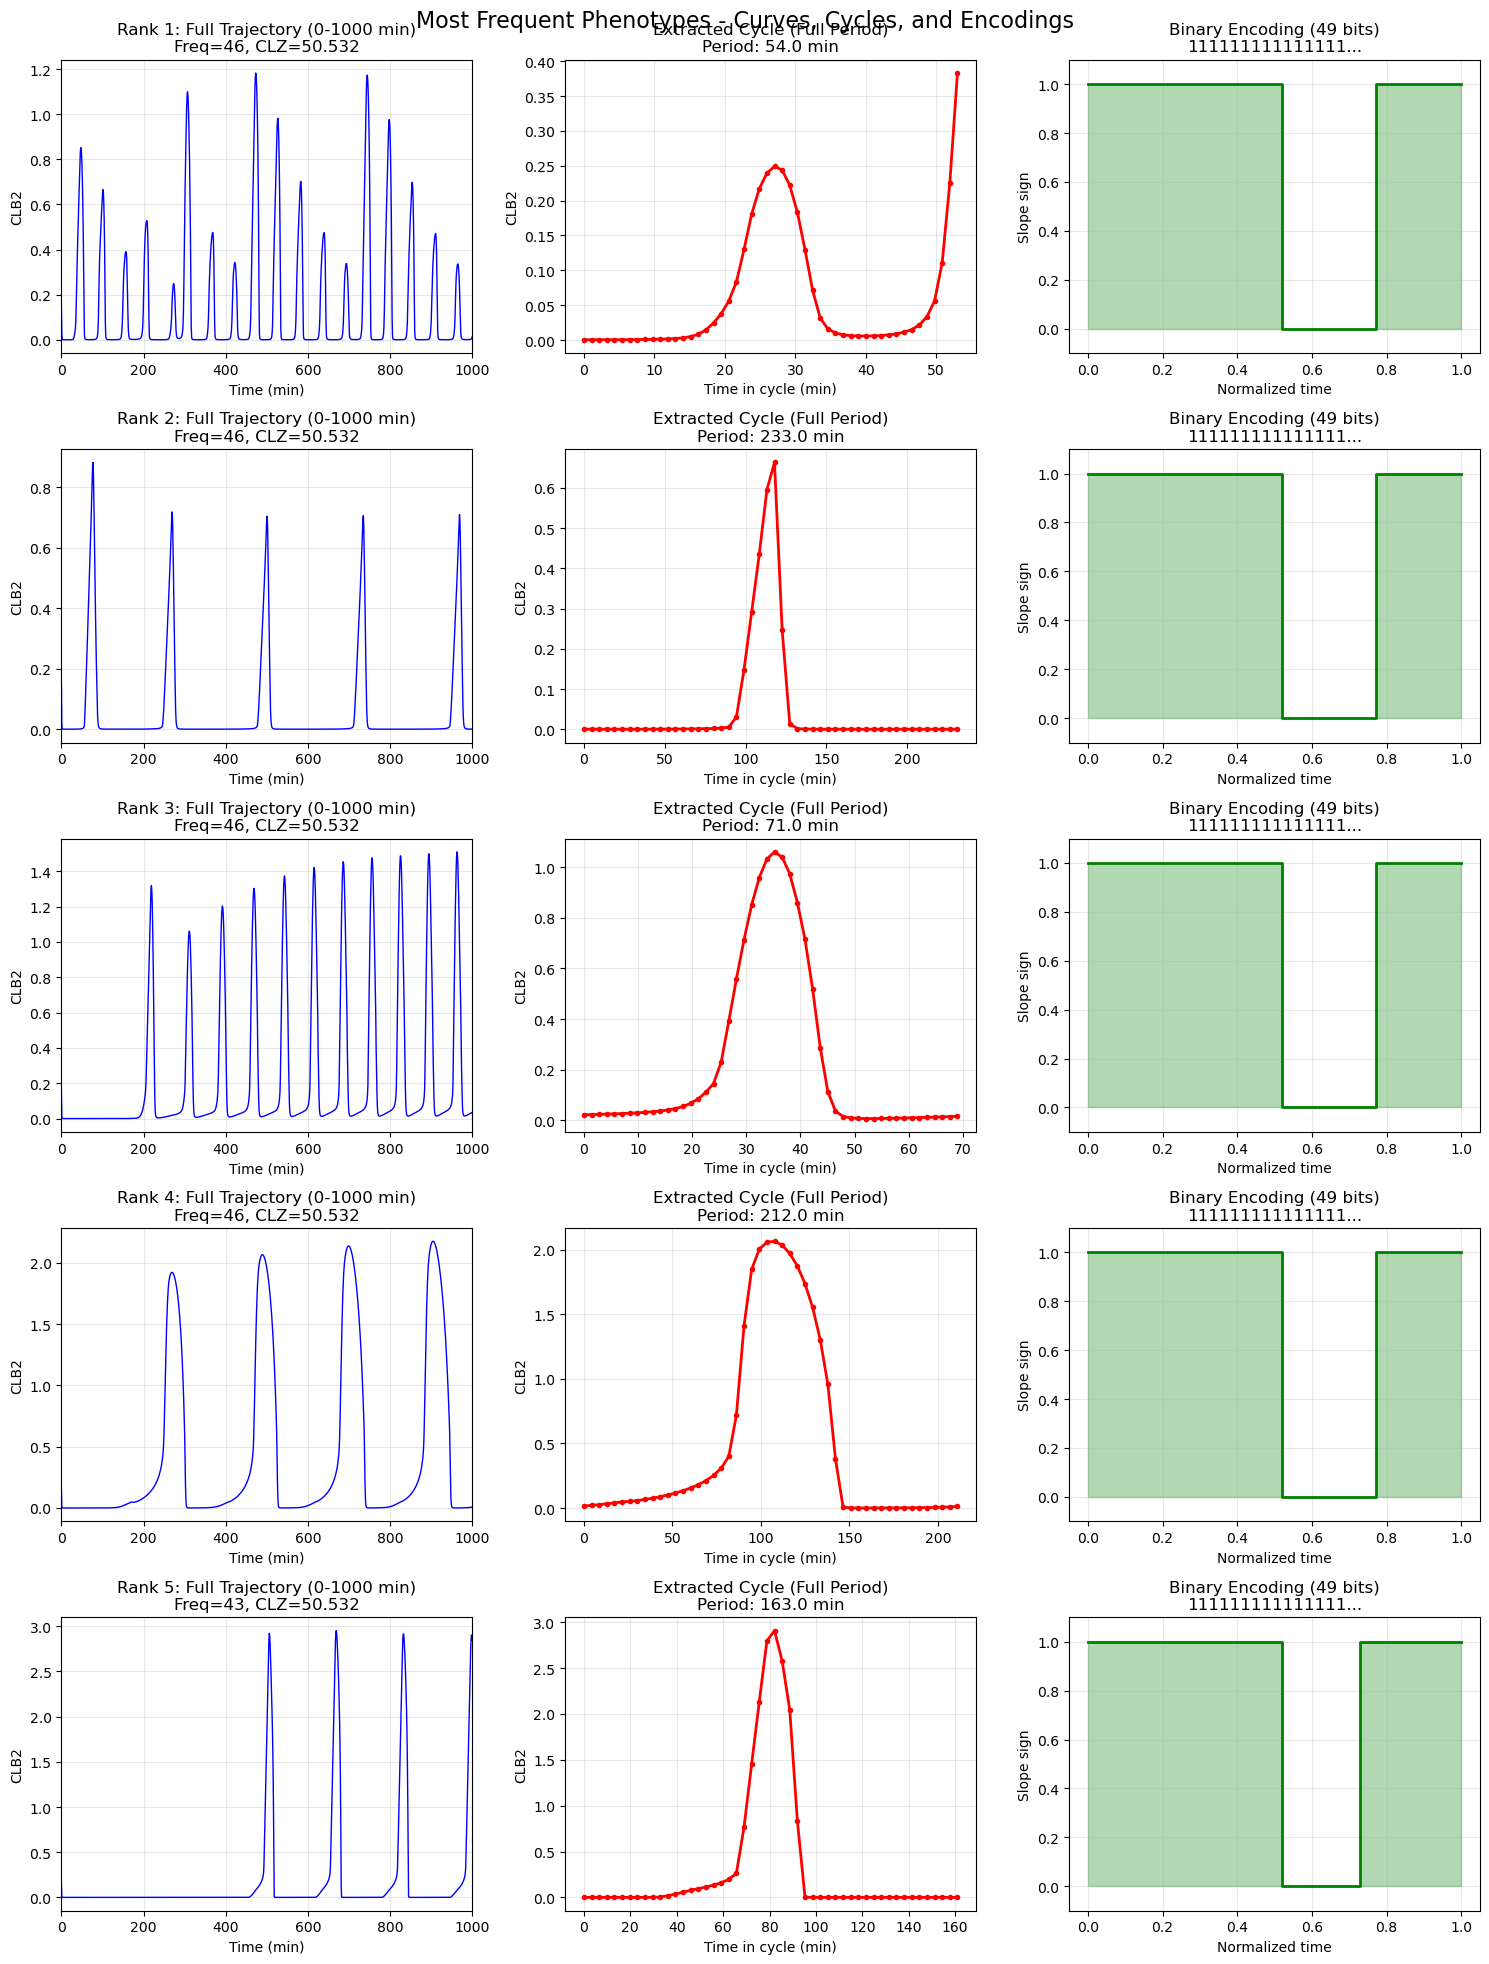


Plotting most complex phenotypes...
Plotting most complex phenotype 1: freq=1, complexity=64.569
Plotting most complex phenotype 2: freq=1, complexity=64.569
Plotting most complex phenotype 3: freq=1, complexity=64.569
Plotting most complex phenotype 4: freq=1, complexity=61.762
Plotting most complex phenotype 1: freq=1, complexity=64.569
Plotting most complex phenotype 2: freq=1, complexity=64.569
Plotting most complex phenotype 3: freq=1, complexity=64.569
Plotting most complex phenotype 4: freq=1, complexity=61.762
Plotting most complex phenotype 5: freq=1, complexity=61.762


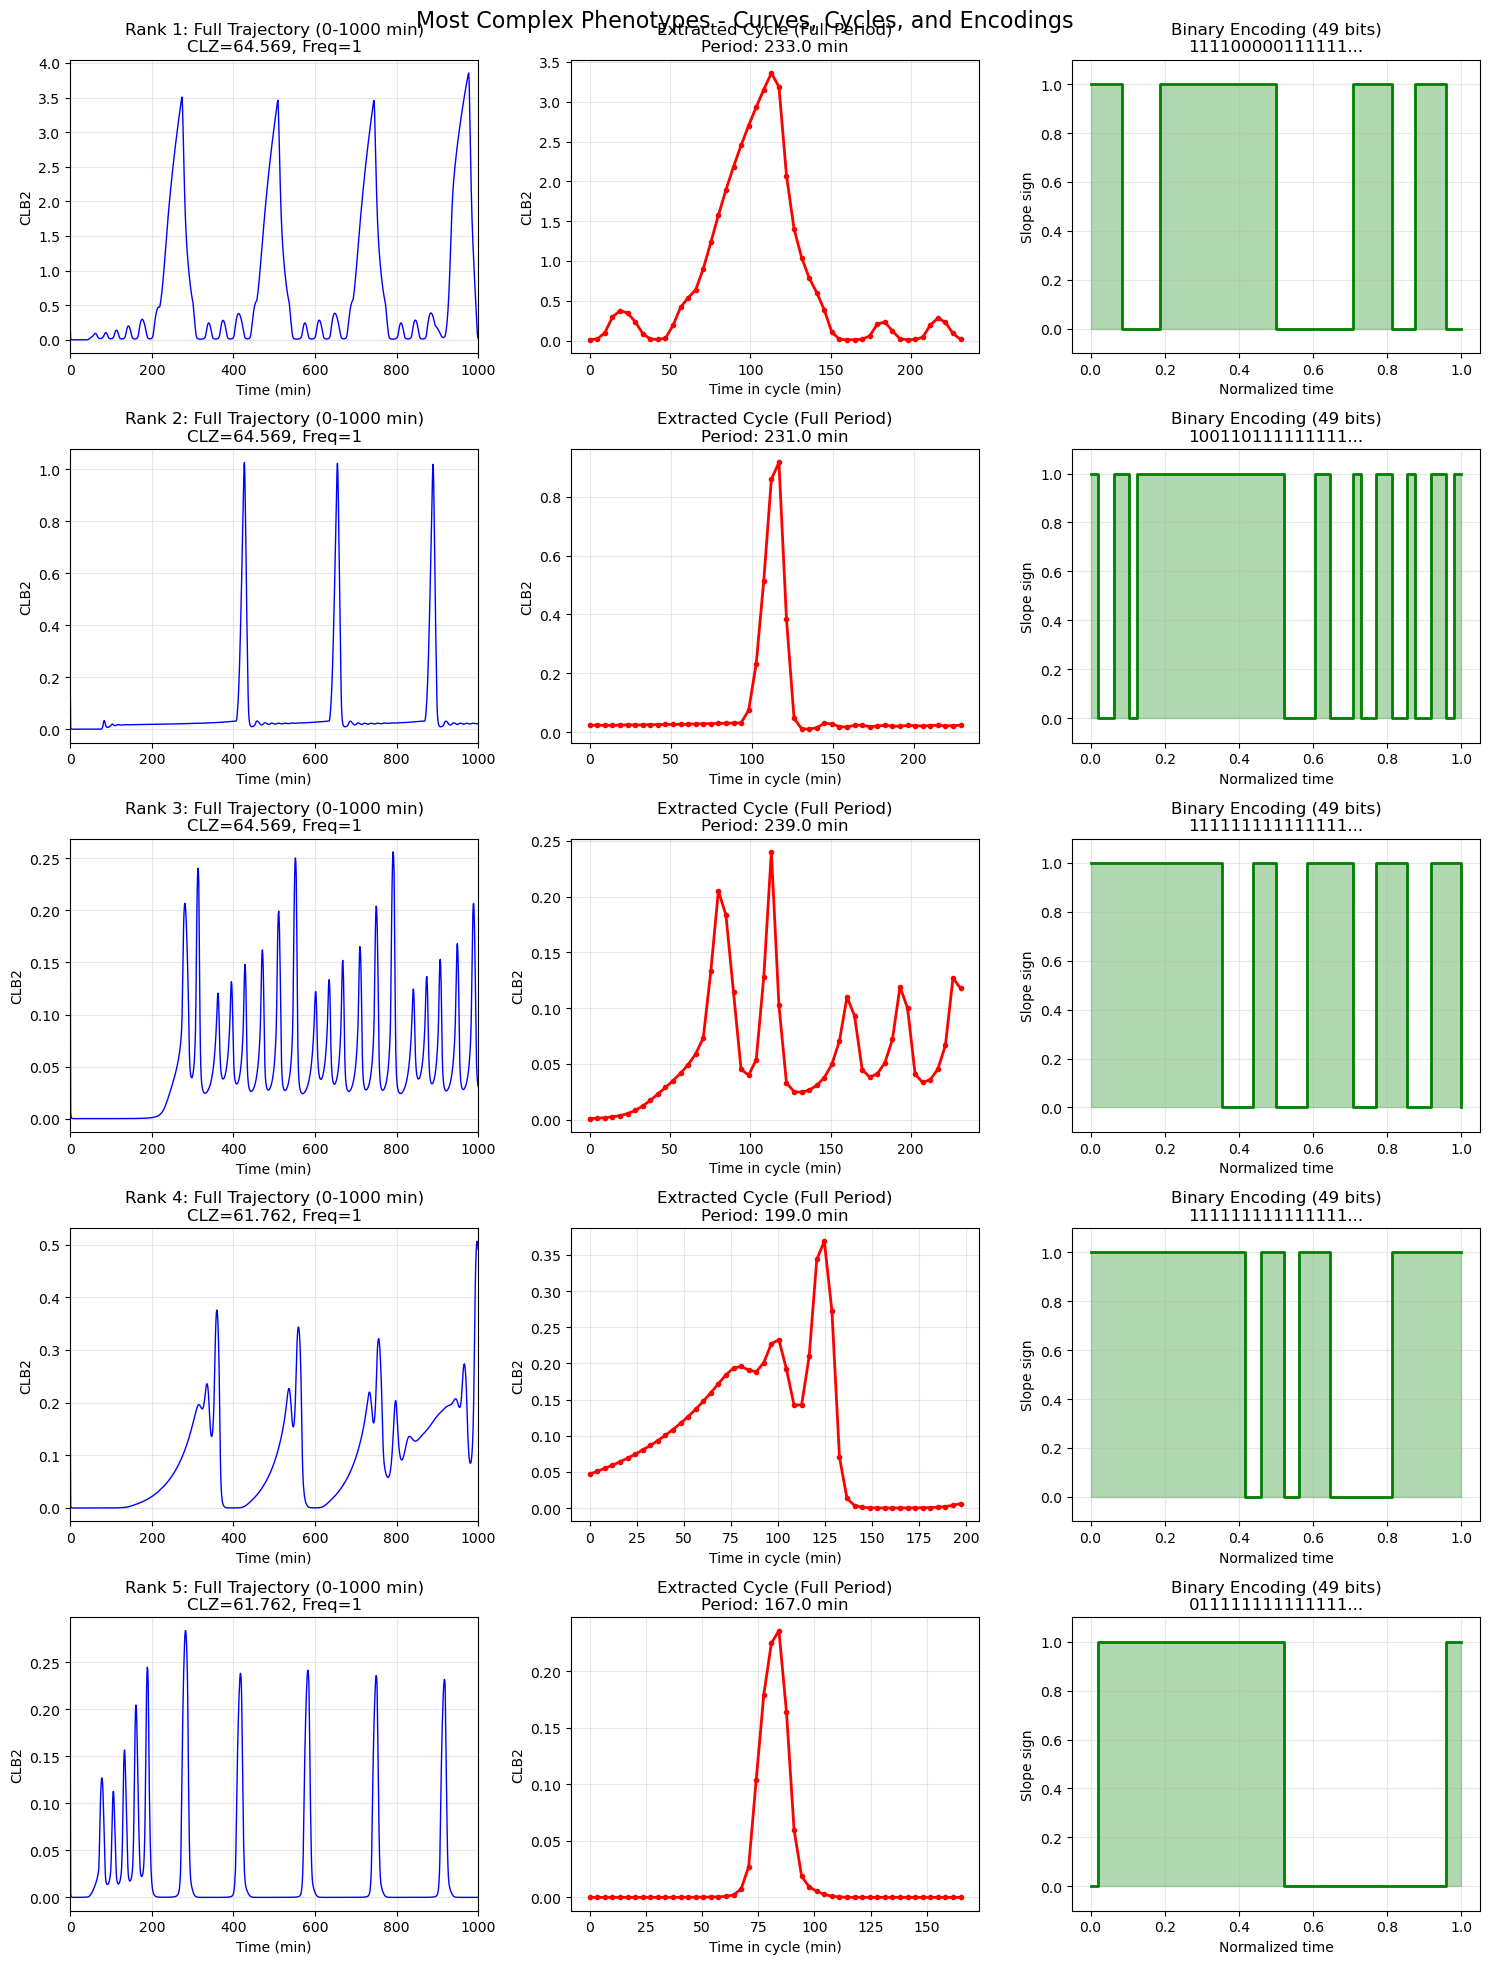


Plotting least complex phenotypes...
Plotting least complex phenotype 1: freq=2, complexity=42.110
Plotting least complex phenotype 2: freq=2, complexity=42.110
Plotting least complex phenotype 3: freq=4, complexity=47.725
Plotting least complex phenotype 4: freq=19, complexity=47.725
Plotting least complex phenotype 5: freq=10, complexity=47.725


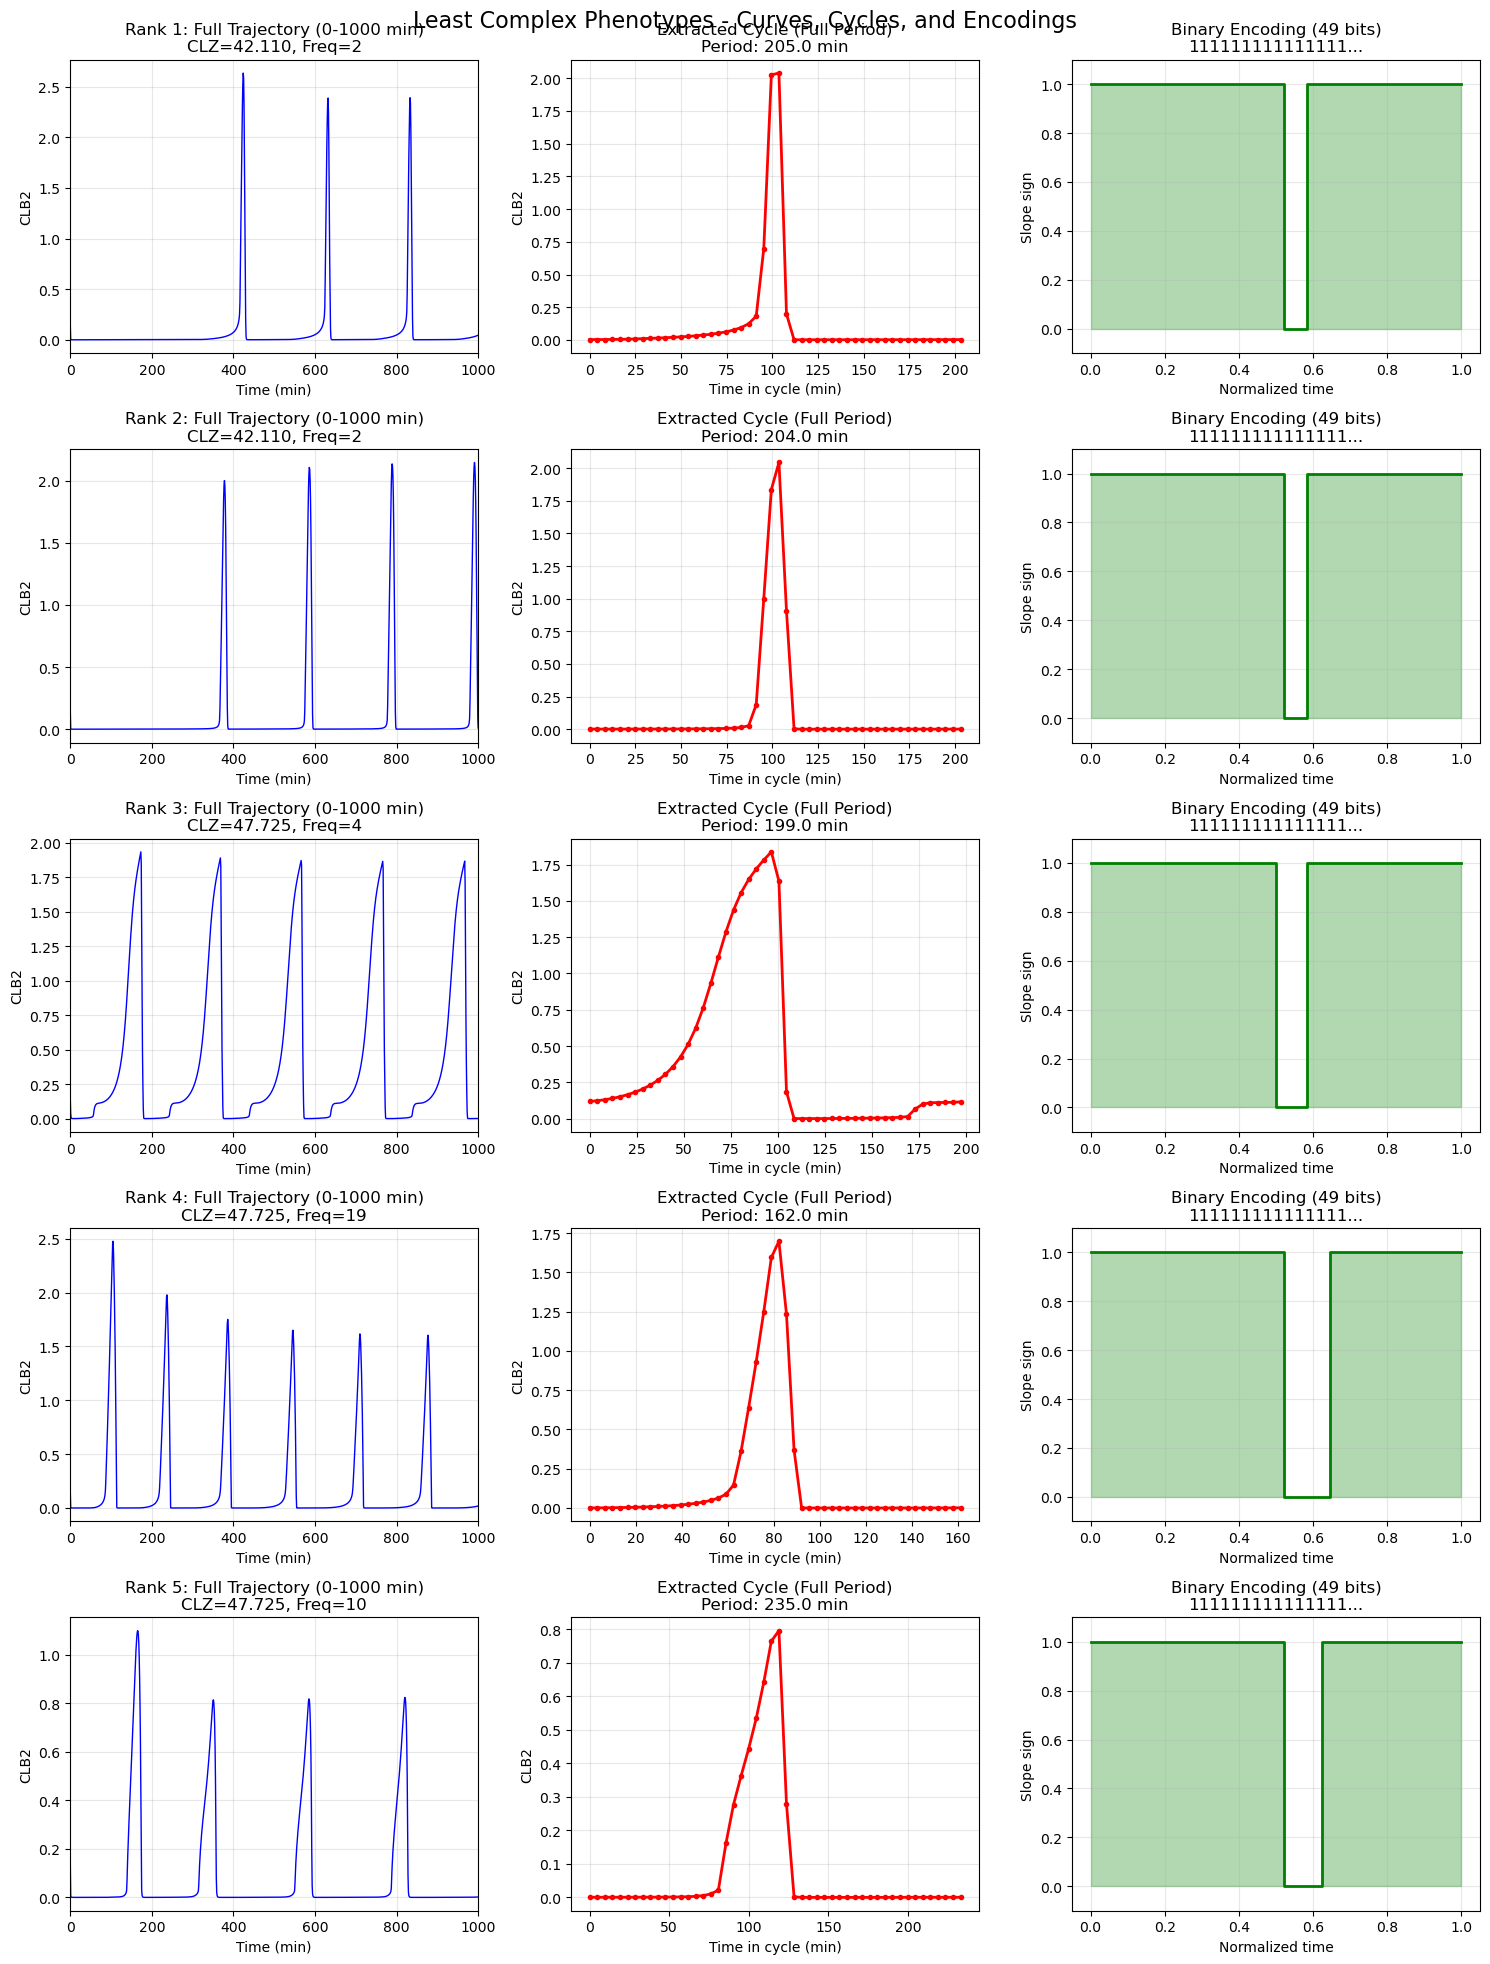


=== MOST FREQUENT PHENOTYPES SUMMARY ===

1. Most Frequent Phenotype:
   Encoding: 111111111111111111111111100000...
   Frequency: 46
   Complexity: 50.532
   Period: 54.0 min
   Genotype (first 10 parameters): [2.0, 2.0, 1.25, 1.75, 0.5, 0.25, 1.75, 1.75, 0.75, 2.0]

2. Most Frequent Phenotype:
   Encoding: 111111111111111111111111100000...
   Frequency: 46
   Complexity: 50.532
   Period: 233.0 min
   Genotype (first 10 parameters): [1.0, 2.0, 0.25, 0.75, 1.5, 1.25, 1.5, 0.5, 0.75, 1.75]

3. Most Frequent Phenotype:
   Encoding: 111111111111111111111111100000...
   Frequency: 46
   Complexity: 50.532
   Period: 71.0 min
   Genotype (first 10 parameters): [1.5, 1.25, 0.25, 2.0, 1.5, 1.75, 0.25, 1.25, 2.0, 1.0]

4. Most Frequent Phenotype:
   Encoding: 111111111111111111111111100000...
   Frequency: 46
   Complexity: 50.532
   Period: 212.0 min
   Genotype (first 10 parameters): [1.25, 1.5, 1.0, 1.75, 0.5, 1.5, 1.75, 0.75, 1.75, 2.0]

5. Most Frequent Phenotype:
   Encoding: 111111111

In [58]:
def plot_tracked_phenotypes(tracked_data, title_prefix, plot_type):
    """Plot tracked phenotypes using stored genotype and phenotype data"""
    
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))
    fig.suptitle(f"{title_prefix} Phenotypes - Curves, Cycles, and Encodings", fontsize=16, y=0.98)
    
    for i, (score, data_tuple) in enumerate(tracked_data):
        encoding, genotype, phenotype_data = data_tuple
        
        # Get stored data
        full_time = phenotype_data['full_time']
        full_clb2 = phenotype_data['full_clb2']
        period = phenotype_data['period']
        complexity = phenotype_data['complexity']
        
        # REGENERATE cycle data using the new improved period extraction method
        # This ensures we get the full-period-window cycles in the plots
        new_period, new_cycle_data = estimate_period(full_time, full_clb2)
        if new_cycle_data is not None:
            cycle_time, cycle_signal = new_cycle_data
            # Coarse-grain the new cycle to 50 points
            coarse_time, coarse_signal = coarse_grain_to_50_steps(cycle_time, cycle_signal)
        else:
            # Fallback to stored data if regeneration fails
            coarse_time = phenotype_data['coarse_time']
            coarse_signal = phenotype_data['coarse_signal']
        
        # Get frequency from final count
        freq = phenotype_counts[encoding]
        
        print(f"Plotting {title_prefix.lower()} phenotype {i+1}: freq={freq}, complexity={complexity:.3f}")
        
        # Plot 1: Full trajectory (FULL TIME from 0 to 1000 minutes)
        axes[i, 0].plot(full_time, full_clb2, 'b-', linewidth=1)
        
        if plot_type == "frequency":
            axes[i, 0].set_title(f"Rank {i+1}: Full Trajectory (0-1000 min)\nFreq={freq}, CLZ={complexity:.3f}")
        else:
            axes[i, 0].set_title(f"Rank {i+1}: Full Trajectory (0-1000 min)\nCLZ={complexity:.3f}, Freq={freq}")
        
        axes[i, 0].set_xlabel("Time (min)")
        axes[i, 0].set_ylabel("CLB2")
        axes[i, 0].set_xlim(0, 1000)  # Ensure we see the full time range
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot 2: Extracted cycle (50 points) - NOW USING NEW METHOD
        axes[i, 1].plot(coarse_time - coarse_time[0], coarse_signal, 'ro-', markersize=3, linewidth=2)
        axes[i, 1].set_title(f"Extracted Cycle (Full Period)\nPeriod: {period:.1f} min")
        axes[i, 1].set_xlabel("Time in cycle (min)")
        axes[i, 1].set_ylabel("CLB2")
        axes[i, 1].grid(True, alpha=0.3)
        
        # Plot 3: Binary encoding visualization
        step_time = np.linspace(0, 1, 49)
        encoding_values = [int(bit) for bit in encoding]
        axes[i, 2].step(step_time, encoding_values, 'g-', linewidth=2, where='post')
        axes[i, 2].fill_between(step_time, 0, encoding_values, step='post', alpha=0.3, color='green')
        axes[i, 2].set_title(f"Binary Encoding (49 bits)\n{encoding[:15]}...")
        axes[i, 2].set_xlabel("Normalized time")
        axes[i, 2].set_ylabel("Slope sign")
        axes[i, 2].set_ylim(-0.1, 1.1)
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"plots/Chen_{title_prefix.lower().replace(' ', '_')}_phenotypes_N{len(encodings)}.png", dpi=300, bbox_inches='tight')
    plt.show()

def print_phenotype_summary(tracked_data, title_prefix):
    """Print summary of tracked phenotypes with their genotypes"""
    print(f"\n=== {title_prefix.upper()} PHENOTYPES SUMMARY ===")
    
    for i, (score, data_tuple) in enumerate(tracked_data):
        encoding, genotype, phenotype_data = data_tuple
        complexity = phenotype_data['complexity']
        period = phenotype_data['period']
        freq = phenotype_counts[encoding]
        
        print(f"\n{i+1}. {title_prefix} Phenotype:")
        print(f"   Encoding: {encoding[:30]}...")
        print(f"   Frequency: {freq}")
        print(f"   Complexity: {complexity:.3f}")
        print(f"   Period: {period:.1f} min")
        print(f"   Genotype (first 10 parameters): {list(genotype.values())[:10]}")

# Create representative phenotype plots using tracked data
print("\n=== GENERATING REPRESENTATIVE PHENOTYPE PLOTS ===")
print("Using stored phenotype and genotype data from sampling...")
print("Regenerating cycles with improved full-period-window method...")

# Get tracked phenotypes
top_frequent = tracker.get_top_frequent()
top_complex = tracker.get_top_complex()
bottom_complex = tracker.get_bottom_complex()

# Plot most frequent phenotypes
print("\nPlotting most frequent phenotypes...")
plot_tracked_phenotypes(top_frequent, "Most Frequent", "frequency")

# Plot most complex phenotypes  
print("\nPlotting most complex phenotypes...")
plot_tracked_phenotypes(top_complex, "Most Complex", "complexity")

# Plot least complex phenotypes
print("\nPlotting least complex phenotypes...")
plot_tracked_phenotypes(bottom_complex, "Least Complex", "complexity")

# Print detailed summaries
print_phenotype_summary(top_frequent, "Most Frequent")
print_phenotype_summary(top_complex, "Most Complex") 
print_phenotype_summary(bottom_complex, "Least Complex")

print("\nRepresentative phenotype plots saved to 'plots/' directory:")
print("  - Chen_most_frequent_phenotypes_N{}.png".format(len(encodings)))
print("  - Chen_most_complex_phenotypes_N{}.png".format(len(encodings)))
print("  - Chen_least_complex_phenotypes_N{}.png".format(len(encodings)))